In [49]:
import pandas as pd
import numpy as np

### Loading the feature functions from CSV and trimming

In [50]:
df = pd.read_csv("ff_valence.csv")

# Save to a CSV file
molecules = df['Mol'].values


molecules = molecules
molecules

array(['LiH', 'NaH', 'KH', 'RbH', 'CsH', 'CsCl', 'LiCl', 'CuI', 'LiF'],
      dtype=object)

### Size Modification and adding parameters to Data Frame

In [51]:
df = df.iloc[:9,0:8]

df['Sum_rad'] = df['RadV_C'] + df['RadV_A']
# # df['Diff_rad'] = df['RadV_A'] - df['RadV_C']
df['Sum_pol'] = df['Pol_C'] + df['Pol_A']
# df['sum_ion'] = df['Ion_C'] + df['Ion_A']
# # df['diff_ion'] = df['Ion_C'] - df['Ion_A']
df

,Mol,Pol_C,Pol_A,RadV_C,RadV_A,CN_C,Ion_C,Ion_A,Sum_rad,Sum_pol
0,LiH,164.1,4.51,182,120,6,5.392,13.590,302,168.61
1,NaH,162.7,4.51,227,120,6,5.139,13.590,347,167.21
2,KH,289.7,4.51,275,120,6,4.341,13.590,395,294.21
3,RbH,319.8,4.51,303,120,6,4.177,13.590,423,324.31
4,CsH,400.6,4.51,343,120,6,3.849,13.590,463,405.11
5,CsCl,400.6,14.60,343,175,6,3.849,12.960,518,415.20
6,LiCl,164.1,14.60,120,175,6,5.392,12.960,295,178.70
7,CuI,46.5,32.90,140,198,4,7.726,10.451,338,79.40
8,LiF,164.1,3.74,120,135,6,5.392,17.423,255,167.84


### making the combinations

In [52]:
## Generating all the cominations of the parameters

import itertools
import numpy as np
import pandas as pd

def generate_combinations_df(params_df, param_names):
    results = []

    # Convert all parameter values to numeric, coercing errors to NaN
    params_df = params_df.apply(pd.to_numeric, errors='coerce')

    # Precompute inverses of all parameters
    # Convert to float to handle integer to negative power issue
    params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)
    params_inv_df.columns = [f"{name}^(-1)" for name in param_names]

    # Combine original parameters and their inverses
    combined_params_df = pd.concat([params_df, params_inv_df], axis=1)
    combined_param_names = list(combined_params_df.columns)

    # Generate all subsets of parameters (combinations)
    for r in range(1, len(combined_param_names) + 1):
        for subset_indices in itertools.combinations(range(len(combined_param_names)), r):

            subset_names = [combined_param_names[i] for i in subset_indices]
            subset = combined_params_df[subset_names]

            # Replace NaN values with 0
            subset = subset.fillna(0)

            # Check if both a parameter and its inverse are in the subset
            invalid = False
            for name in subset_names:
                if name.endswith("^(-1)") and name[:-5] in subset_names:
                    invalid = True
                    break
                elif name in param_names and f"{name}^(-1)" in subset_names:
                    invalid = True
                    break

            if invalid:
                continue

            # Compute results for valid subsets
            expr_str = " * ".join(subset_names)
            expr_val = subset.prod(axis=1)
            results.append((expr_str, expr_val))

    return results

In [53]:

import os
import pandas as pd

takeSaved = False

all_expressions = []
expressions = []
# Define file name to save/load the results
cache_file = "cached_expressions.pkl"

if os.path.exists(cache_file) and takeSaved:
    # Load the cached results if they exist
    expressions = pd.read_pickle(cache_file)
    all_expressions = list(expressions.itertuples(index=False, name=None))
    print("Loaded cached expressions.")
else:
    # Perform the costly computation if cache does not exist
    print("Calculating expressions...")
    param_names = list(df.iloc[:,1:].columns)
    all_expressions = generate_combinations_df(df.iloc[:, 1:], param_names)
    expressions = pd.DataFrame(all_expressions, columns=['Expression', 'Value'])

    # Save the results to cache
    expressions.to_pickle(cache_file)
    print("Expressions cached.")

# Print the shape of the expressions DataFrame
print(expressions.shape)


Calculating expressions...


C:\Users\user\AppData\Local\Temp\ipykernel_32064\1172358489.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  params_inv_df = params_df.applymap(lambda x: np.power(float(x), -1) if pd.notnull(x) and x != 0 else np.nan)


Expressions cached.
(19682, 2)


In [54]:
expressions.head()

,Expression,Value
0,Pol_C,0 164.1 1 162.7 2 289.7 3 319.8 4 ...
1,Pol_A,0 4.51 1 4.51 2 4.51 3 4.51 4 ...
2,RadV_C,0 182 1 227 2 275 3 303 4 343 5...
3,RadV_A,0 120 1 120 2 120 3 120 4 120 5...
4,CN_C,0 6 1 6 2 6 3 6 4 6 5 6 6 ...


### Addition results to the combinations

In [55]:
%store -r res
res

[14.137466826376718,
 14.087159279098158,
 14.02702180402777,
 12.930918115689444,
 12.275605094480198,
 3.2325958680570794,
 5.11791434948661,
 3.5739198265668453,
 4.719651538728355]

In [56]:
values_dict = {expr_str: expr_val for expr_str, expr_val in all_expressions}
values = pd.DataFrame(values_dict)
values['res'] = res

### Finding Corelation

In [57]:

correlation = values.corr()

correlation.shape

(19683, 19683)

In [58]:
results=correlation['res'].abs().sort_values(ascending=False)
print(results.iloc[0:20])
top_vars = results.iloc[1:20].index

res                                                                                       1.000000
RadV_C * CN_C * Ion_C * RadV_A^(-1) * Ion_A^(-1) * Sum_rad^(-1)                           0.976181
Pol_C * RadV_C * Ion_C * RadV_A^(-1) * Ion_A^(-1) * Sum_rad^(-1) * Sum_pol^(-1)           0.975665
Pol_C * RadV_A^(-1) * CN_C^(-1) * Ion_A^(-1) * Sum_pol^(-1)                               0.974741
RadV_A * CN_C * Ion_A * Sum_pol * Pol_C^(-1)                                              0.971182
RadV_A * Ion_A * Sum_rad * RadV_C^(-1) * CN_C^(-1) * Ion_C^(-1)                           0.965857
RadV_A^(-1) * Ion_A^(-1)                                                                  0.962337
Pol_C * RadV_C * CN_C * Ion_C * RadV_A^(-1) * Ion_A^(-1) * Sum_rad^(-1) * Sum_pol^(-1)    0.960766
RadV_A * Ion_A * Sum_rad * Sum_pol * Pol_C^(-1) * RadV_C^(-1) * Ion_C^(-1)                0.952499
CN_C * RadV_A^(-1) * Ion_A^(-1)                                                           0.952263
RadV_A * I

### Final Results

In [59]:
results=correlation['res'].abs().sort_values(ascending=False)
print(results.iloc[0:20])
top_vars = results.iloc[1:20].index


res                                                                                       1.000000
RadV_C * CN_C * Ion_C * RadV_A^(-1) * Ion_A^(-1) * Sum_rad^(-1)                           0.976181
Pol_C * RadV_C * Ion_C * RadV_A^(-1) * Ion_A^(-1) * Sum_rad^(-1) * Sum_pol^(-1)           0.975665
Pol_C * RadV_A^(-1) * CN_C^(-1) * Ion_A^(-1) * Sum_pol^(-1)                               0.974741
RadV_A * CN_C * Ion_A * Sum_pol * Pol_C^(-1)                                              0.971182
RadV_A * Ion_A * Sum_rad * RadV_C^(-1) * CN_C^(-1) * Ion_C^(-1)                           0.965857
RadV_A^(-1) * Ion_A^(-1)                                                                  0.962337
Pol_C * RadV_C * CN_C * Ion_C * RadV_A^(-1) * Ion_A^(-1) * Sum_rad^(-1) * Sum_pol^(-1)    0.960766
RadV_A * Ion_A * Sum_rad * Sum_pol * Pol_C^(-1) * RadV_C^(-1) * Ion_C^(-1)                0.952499
CN_C * RadV_A^(-1) * Ion_A^(-1)                                                           0.952263
RadV_A * I

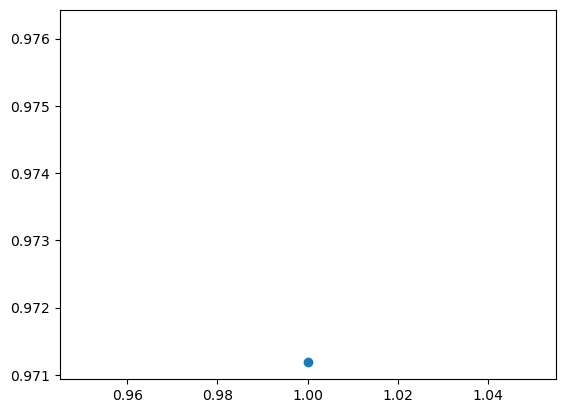

1.0


In [60]:
import matplotlib.pyplot as plt

plt.scatter(results['res'],results[top_vars[3]])
plt.plot(results['res'],results[top_vars[0]])
plt.show()

values[top_vars[0]]


# param = df['Cat_EN']*df['Ani_EN']*df['Rad_C']*df['CN']*df['Ion_C']*df['Ion_A']



# y = list(values[top_vars[0]])[:4]+list(values[top_vars[0]])[5:]
# x = list(values['res'])[:4]+list(values['res'])[5:]

# plt.scatter(x,y)
# x

print(results['res'])

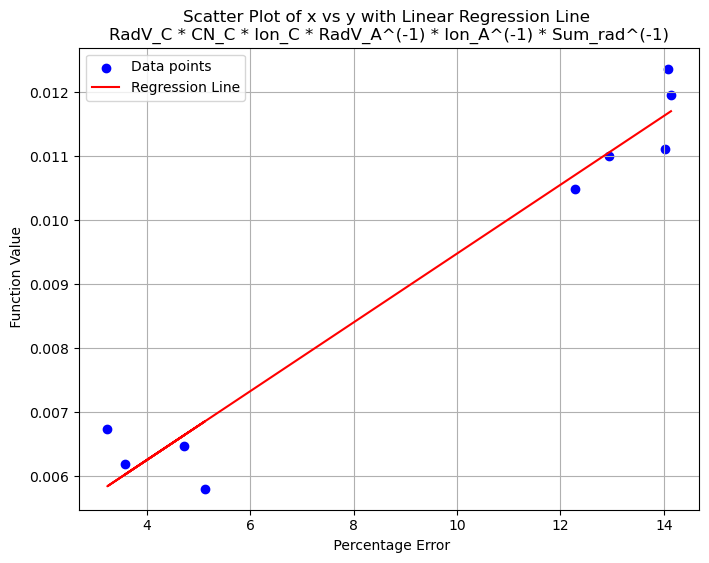

(0.9529298327274175, 3.154248729385633e-07, 'y = 0.0005x + 0.0041')

In [61]:
param = top_vars[0]

y = values[param]
x = values['res']

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming x and y are Pandas Series
# Reshape x to a 2D array
x_reshaped = x.values.reshape(-1, 1)  # Convert x to a 2D array (n, 1)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(x_reshaped, y)

# Get the slope (coefficient) and intercept
slope = model.coef_[0]  # model.coef_ gives the slope of the line
intercept = model.intercept_  # model.intercept_ gives the intercept

# Predict y values using the linear model
y_pred = model.predict(x_reshaped)

# Plot the data points and the regression line
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', label='Data points')
plt.plot(x, y_pred, color='red', label='Regression Line')
plt.title(f'Scatter Plot of x vs y with Linear Regression Line \n{param}')
plt.xlabel(' Percentage Error')
plt.ylabel(' Function Value')
plt.grid()
plt.legend()
plt.show()

# Calculate R^2 and MSE
r_squared = r2_score(y, y_pred)
msd = mean_squared_error(y, y_pred)

# Display the equation of the line
equation = f"y = {slope:.4f}x + {intercept:.4f}"
r_squared, msd, equation
